### `Import Libraries`

In [67]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from io import StringIO
from sklearn.linear_model import LinearRegression
from statsmodels.stats import diagnostic as diag
from statsmodels.compat import lzip
from lime import lime_tabular
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
%matplotlib inline

### `Sample Data`

In [2]:
companya_sales_data = """
Manufacture,Product_Sell,Revenue_Generation
11,10,1000
12,15,1400
18,18,1800
24,22,2400
22,26,2600
25,30,2800
10,5,700
33,31,2900
"""

df = pd.read_table(StringIO(companya_sales_data), sep=",")
display(HTML(df.to_html()))

,Manufacture,Product_Sell,Revenue_Generation
0,11,10,1000
1,12,15,1400
2,18,18,1800
3,24,22,2400
4,22,26,2600
5,25,30,2800
6,10,5,700
7,33,31,2900


### `3rd Plot : With indep. variables vs dep. variable`

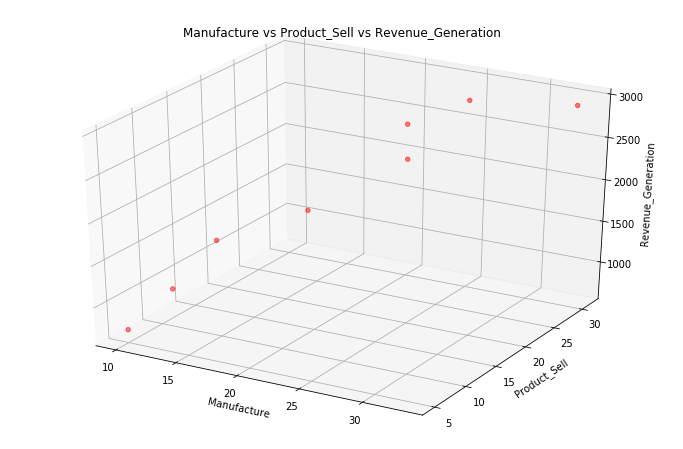

In [91]:
prediction_flag = False

col_1 = "Manufacture"; col_2 = "Product_Sell"; col_3 = "Revenue_Generation";

fig = plt.figure(figsize=(12,8))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[col_1],df[col_2],df[col_3],c='red', marker='o', alpha=0.5)
# ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='b', alpha=0.3)
if prediction_flag == True:
    xs = np.tile(np.arange(31), (31,1))
    ys = np.tile(np.arange(31), (31,1)).T
    # zs = xs*coefs[0]+ys*coefs[1]+intercept
    zs = xs*slope1+ys*slope2+intercept
    ax.plot_surface(xs,ys,zs, color='b', alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.show()

## `Multi Linear Regression - Assumptions`

### `Linearity Check between [indep.vars] & [dep.var]`

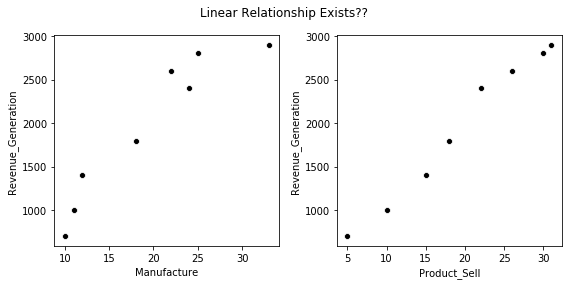

In [3]:
# plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.scatterplot("Manufacture", "Revenue_Generation", data=df, ax=ax[0], marker='o', color='black')
sns.scatterplot("Product_Sell", "Revenue_Generation", data=df, ax=ax[1], marker='o', color='black')
plt.suptitle("Linear Relationship Exists??")
plt.tight_layout()
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

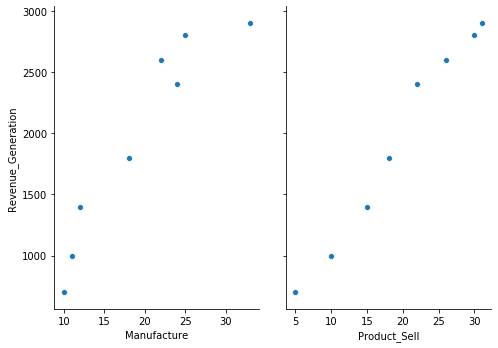

In [26]:
sns.pairplot(df, x_vars=['Manufacture','Product_Sell'], y_vars='Revenue_Generation', size=5, aspect=0.7)
plt.show()

- **`From the plot`**
  - There is roughly linear relation between `Manufacture` & `Revenue_Generation`
  - There is linear relation between `Product_Sell` & `Revenue_Generation`

### `Variables follow a Normal Distribution`
- we want to make sure that for each x value, y is a random variable following a normal distribution and its mean lies on the regression line. 
- To take a deeper dive into probability distributions with python you can read this article: Fitting Probability Distributions with Python 
- One of the ways to visually test for this assumption is through the use of the Q-Q-Plot. 
- Q-Q stands for Quantile-Quantile plot and is a technique to compare two probability distributions in a visual manner.
- How do you know if your variable follows a normal distribution? Do you see the red line in the chart above? The points must lie on this line to conclude that it follows a normal distribution

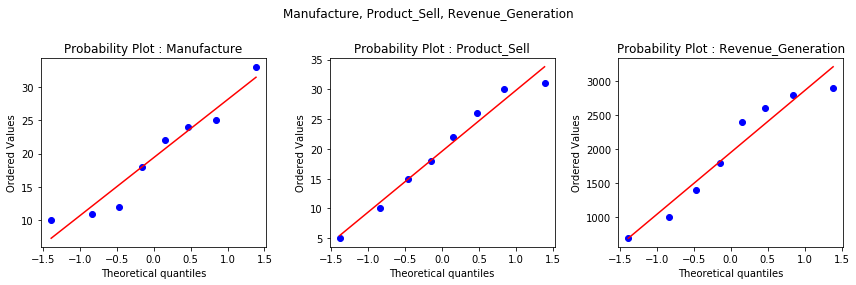

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

stats.probplot(df.iloc[:,0], dist="norm", plot=ax[0])
ax[0].set_title("Probability Plot : Manufacture")
stats.probplot(df.iloc[:,1], dist="norm", plot=ax[1])
ax[1].set_title("Probability Plot : Product_Sell")
stats.probplot(df.iloc[:,2], dist="norm", plot=ax[2])
ax[2].set_title("Probability Plot : Revenue_Generation")
plt.suptitle("Manufacture, Product_Sell, Revenue_Generation")
plt.tight_layout()
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()

 **`From the plot`**
  - It seems to be all the 3 variables are roughly normally distributed. Because all 3 vars data points lie's on this red line.

### `There is little or no Multicollinearity`
- Multicollinearity is a fancy way of saying that your independent variables are highly correlated with each other.
- Remember the name of your X’s, they are called `independent variables for a reason`. 
- If `multicollinearity exists between them, they are no longer independent` and this generates issues when modeling linear regressions.
- `If you find any values in which the absolute value of their correlation is >=0.8, the multicollinearity assumption is being broken`

In [16]:
#generate correlation matrix
corr = df.corr()
''' 
With our corr variable holding the correlation matrix, apply styling to using the coolwarm color map. 
Low values will have a blue color while higher values will become “hot” and thus the red
'''
corr.style.background_gradient(cmap='coolwarm')

,Manufacture,Product_Sell,Revenue_Generation
Manufacture,1,0.931869,0.944058
Product_Sell,0.931869,1,0.989697
Revenue_Generation,0.944058,0.989697,1


 **`From the correlation matrix`**
  - Here Manufacture & Product_Sell show correlation > 0.8 i.e., 0.93. So both these are strongly correlated which results into multi-collinearity situation.
  - As, Product_Sell has much more correlation with resp. var [Revenue_Generation] that Manufacture, so we take off the Manufacture var. from the predictors list in model training

In [27]:
df_1 = df[["Product_Sell", "Revenue_Generation"]].copy(deep=True)
df_1 

,Product_Sell,Revenue_Generation
0,10,1000
1,15,1400
2,18,1800
3,22,2400
4,26,2600
5,30,2800
6,5,700
7,31,2900


### `Train Model Using - Statsmodels`

In [73]:
lm = LinearRegression()

df_train = df.loc[:len(df)-3]

X_train = np.array(df_train["Product_Sell"]).reshape(-1, 1)
Y_train = np.array(df_train["Revenue_Generation"]).reshape(-1, 1)

# to get intercept -- this is optional
X_train = sm.add_constant(X_train)

##### Fit the Regression Model #####
reg = sm.OLS(Y_train, X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     118.0
Date:                Sat, 08 Jan 2022   Prob (F-statistic):           0.000408
Time:                        00:15:35   Log-Likelihood:                -37.153
No. Observations:                   6   AIC:                             78.31
Df Residuals:                       4   BIC:                             77.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6001    187.765      0.344      0.748    -456.718     585.918
x1            95.9702      8.837     10.861      0.000      71.436     120.505
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.587
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.564
Skew:                           0.725   Prob(JB):                        0.754
Kurtosis:                       2.610   Cond. No.                         67.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- **`Coefficients Interpretation`**
  - `Regression line`
    - The regression line with equation [y = 64.6001 + (95.9702 * Product_Sell)], is helpful to predict the value of the `Revenue_Generation` from the given values of the [`Product_Sell`].
  - `Regression coefficients (slope) and constant (y-intercept)`
    - The regression coefficients or slope (95.9702) represent the change in the y per unit change in the X variable. It means the value of `Revenue_Generation` increases by 95.9702 with each unit increase in `Product_Sell`.
    - The y-intercept (64.6001) represents the value of y when the X variable has a value of 0. Here need to be cautious to interpret the y-intercept as sometimes the value (X=0) does not make any sense (e.g. island area, speed of the car, or height of the person). In such cases, the values within the range of X should be considered interpreting the y-intercept.
    - The p values i.e., 0.000 associated with the Product_Sell is significant (p < 0.05). It suggests that the `Product_Sell` significantly influences the `Revenue_Generation`.
  - `ANOVA`
    - In regression, the ANOVA tests the null hypothesis that there is no relationship between the independent variable (X) and dependent (y) variable i.e it tests the null hypothesis that regression coefficient equal to zero (b=0).
    - From ANOVA F test, the p value is significant (<0.05), which suggests that there is a significant relationship between [`Product_Sell`] and `Revenue_Generation`. The independent variable (X) can reliably predict the dependent (y) variable.
  - `Coefficient of determination (R-Squared and adjusted R-Squared)`
    - The coefficient of determination (R-Squared) is 0.967 (96.7%), which suggests that 96.7% of the variance in `Revenue_Generation` can be explained by [`Product_Sell`]. 
    - Adjusted R-Squared is useful where there are multiple X variables in the model

### `Train Model Using - Sklearn`

In [93]:
lm = LinearRegression()

df_train = df.loc[:len(df_1)-3]

X_train = np.array(df_train["Product_Sell"]).reshape(-1, 1)
Y_train = np.array(df_train["Revenue_Generation"]).reshape(-1, 1)

##### Train Model #####
lm.fit(X_train, Y_train)
# lm.coef_[0]
print("Coefficient --> ", lm.coef_)
print("Intercept --> ", lm.intercept_)

Coefficient -->  [[95.97024179]]
Intercept -->  [64.60012399]


- **`Coefficients Impact - Before Scaled`**

              Coefficients
Product_Sell     95.970242


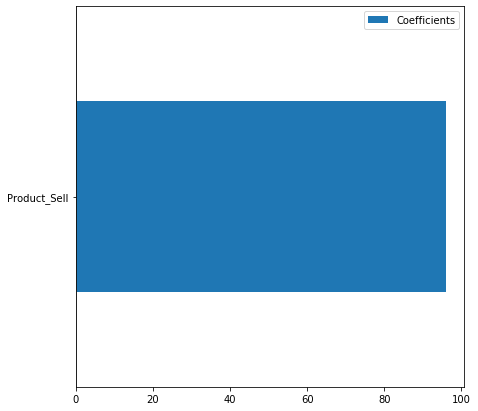

In [97]:
coefs = pd.DataFrame(lm.coef_, columns=["Coefficients"], index=["Product_Sell"])
print(coefs)

coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

- **`Coefficients Impact - After Scaled`**
  - Multiplying the coefficients by the standard deviation of the related feature would reduce all the coefficients to the same unit of measure. 
  - As we will see after this is equivalent to normalize numerical variables to their standard deviation, as .
  - In that way, we emphasize that the greater the variance of a feature, the larger the weight of the corresponding coefficient on the output, all else being equal.
  - https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#scaling-num

  - `I think scaling of regression coefficients would be useful in case we have more than 2 predictors in Model Training`

Before Scaled : lm.coef_ -->  95.97024178549286
stdev -->  6.693695209341068
After Scaled : -->  642.3955476788575
              Coefficients
Product_Sell    642.395548


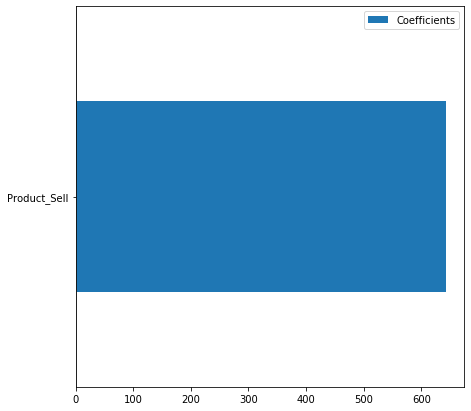

In [105]:
print("Before Scaled : lm.coef_ --> ", lm.coef_[0][0])
print("stdev --> ", np.std(np.array(df_train["Product_Sell"]), axis=0))
scaled_coef = lm.coef_[0][0] * np.std(np.array(df_train["Product_Sell"]), axis=0)
print("After Scaled : --> ", scaled_coef)

coefs = pd.DataFrame(scaled_coef, columns=["Coefficients"], index=["Product_Sell"])
print(coefs)

coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

- **`Observation`**
- An increase of the `Product_Sell` will induce an increase of the `Revenue_Generation` when all other features remain constant.

### `Mean of Residuals`
- Residuals as we know are the differences between the true value and the predicted value. 
- One of the assumptions of linear regression is that the mean of the residuals should be zero.

In [83]:
predictions_list = lm.predict(X_train)
df_train["Predictions"] = predictions_list
display(HTML(df_train.to_html()))

,Manufacture,Product_Sell,Revenue_Generation,Predictions
0,11,10,1000,1024.302542
1,12,15,1400,1504.153751
2,18,18,1800,1792.064476
3,24,22,2400,2175.945443
4,22,26,2600,2559.826410
5,25,30,2800,2943.707378


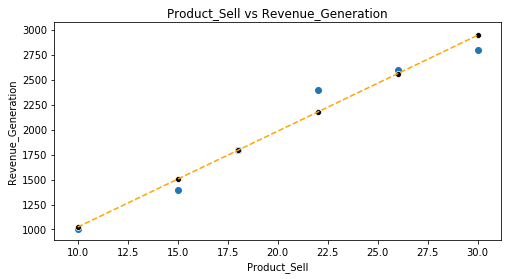

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
x_col = "Product_Sell"
y_col = "Revenue_Generation"
plt.scatter(x_col, y_col, data=df_train)
ax = sns.lineplot(x_col, "Predictions", data=df_train, color = "orange")
ax.lines[0].set_linestyle("--")
sns.scatterplot(x_col, "Predictions", data=df_train, color = 'black')
ax.get_legend().remove()
plt.xlabel(x_col)
plt.ylabel(y_col)
# plt.title("Product_Sell vs Revenue_Generation: $Y_i$ vs $\hat{Y}_i$")
plt.title("{} vs {}".format(x_col, y_col))
plt.show()

In [34]:
residuals = df_train.Revenue_Generation-df_train.Predictions
mean_residuals = np.mean(residuals)
# print("Mean of Residuals {}".format(mean_residuals))
print("Mean of Residuals : {:.22f}".format(float(mean_residuals)))

Mean of Residuals : 0.0000000000000378956126


### `Observation`
- It is very near to zero. So this assumption matches.

### `Check for Homoscedasticity`
- Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. 
- By plotting the error terms with predicted terms we can check that there should not be any pattern in the error terms.
- Detecting heteroscedasticity!
  - Graphical Method: Firstly do the regression analysis and then plot the error terms against the predicted values( Yi^). If there is a definite pattern (like linear or quadratic or funnel shaped) obtained from the scatter plot then heteroscedasticity is present

df_train.Predictions.tolist() -->  [1024.3025418474892, 1504.1537507749536, 1792.064476131432, 2175.9454432734037, 2559.826410415375, 2943.7073775573463]
residuals -->  [-24.302541847489238, -104.15375077495355, 7.935523868567998, 224.05455672659627, 40.173589584625006, -143.70737755734626]


Text(0.5, 1.0, 'Residuals vs fitted values plot for homoscedasticity check')

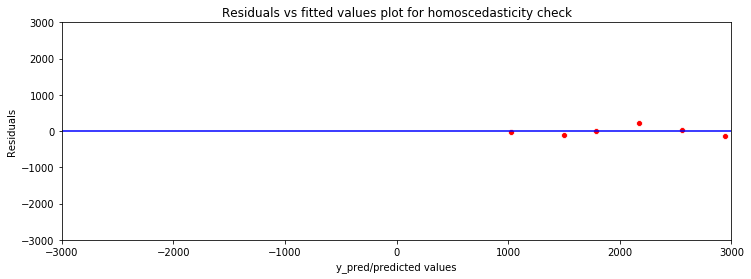

In [61]:
print("df_train.Predictions.tolist() --> ", df_train.Predictions.tolist())
print("residuals --> ", residuals.tolist())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
sns.scatterplot(df_train.Predictions.tolist(),residuals, ax = ax, color='red')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-3000,3000)
plt.xlim(-3000,3000)
sns.lineplot([-3000,3600],[0,0],color='blue', ax = ax)
plt.title('Residuals vs fitted values plot for homoscedasticity check')

### `Observation`
- All residuals are very near to zero line & has no patterns. So there is no heteroscedasticity

### `Goldfeld Quandt Test`
- Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.
- Null Hypothesis: Error terms are homoscedastic
- Alternative Hypothesis: Error terms are heteroscedastic

- Now we will be applying tests.
- A tip is to keep in mind that if we want 95% confidence on our findings and tests then the p-value should be less than 0.05 to be able to reject the null hypothesis. 
- Remember, a researcher or data scientist would always aim to reject the null hypothesis.

In [59]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 9.81987084635548), ('p-value', 0.09242254498230316)]

### `Observation`
- The p-value is 0.092 > 0.05 hence we can't reject it's null hypothesis. And we can say that the residuals have constant variance i.e., homoscedastic

### `Check for Normality of error terms/residuals`

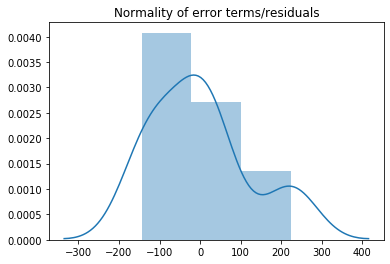

In [60]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

- **`Observation`**
  - The residual terms are pretty much normally distributed for the number of test points we took. 
  - Remember the central limit theorem which says that as the sample size increases the distribution tends to be normal. 
  - A skew is also visible from the plot. It's very difficult to get perfect curves, distributions in real life data.

### `No autocorrelation of residuals`
- When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. 
- Though it is more evident in time series data.¶
- In plain terms autocorrelation takes place when there's a pattern in the rows of the data. 
- This is usual in time series data as there is a pattern of time for eg. Week of the day effect which is a very famous pattern seen in stock markets where people tend to buy stocks more towards the beginning of weekends and tend to sell more on Mondays.
- There should not be autocorrelation in the data, if the error terms doesn't form any pattern

Text(0.5, 1.0, 'Residuals vs fitted values plot for autocorrelation check')

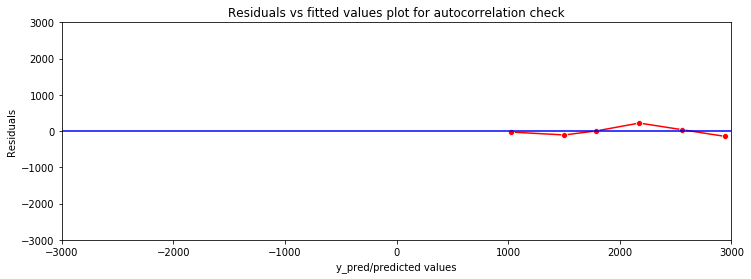

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
p = sns.lineplot(df_train.Predictions.tolist(),residuals.tolist(),marker='o',color='red', ax = ax)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
# plt.ylim(-10,10)
# plt.xlim(0,26)
# p = sns.lineplot([0,26],[0,0],color='red')
plt.ylim(-3000,3000)
plt.xlim(-3000,3000)
sns.lineplot([-3000,3600],[0,0],color='blue', ax = ax)
plt.title('Residuals vs fitted values plot for autocorrelation check')

### `Observation`
- All residuals are very near to zero line & has no patterns. So there is no heteroscedasticity

### `Ljungbox test`
- Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.
- Null Hypothesis: Autocorrelation is absent.
- Alternative Hypothesis: Autocorrelation is present.

In [70]:
min(diag.acorr_ljungbox(residuals.tolist() , lags = 5)[1])

0.07112688623336343

### `Observation`
- Since p value is greater than 0.05. i.e., 0.07 > 0.05. we can't reject the null hypothesis. So null-hypothesis is true.

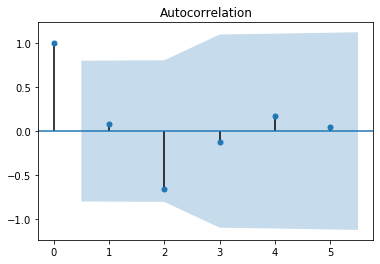

In [71]:
# autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=5)
plt.show()

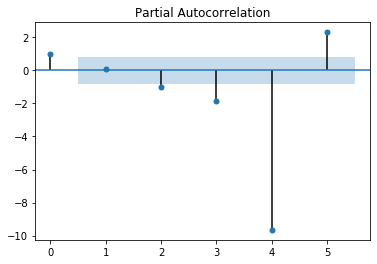

In [72]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(residuals, lags=5)
plt.show()

### `Observation`
- The results doesn't show signs of autocorelation since there are spikes inside the blue confidence interval region.

### `Predictions on Test Data`

In [87]:
##### Predictions on Unseen : Test Data #####
df_test = df.loc[max(df_train.index.tolist())+1:]
X_test = np.array(df_test["Product_Sell"]).reshape(-1, 1)
Y_pred = lm.predict(X_test)
df_test["Predictions"] = Y_pred

display(HTML(df_test.to_html()))

,Manufacture,Product_Sell,Revenue_Generation,Predictions
6,10,5,700,544.451333
7,33,31,2900,3039.677619


### `Predictions on Unseen Data`

In [89]:
''' 
Product_Sell = [1, 20]
'''
data = np.array([1, 20]).reshape(-1, 1)
Y_pred = lm.predict(data)
print(Y_pred)

[[ 160.57036578]
 [1984.0049597 ]]
